In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from transformers import pipeline
from sklearn.metrics import accuracy_score, mean_absolute_error, classification_report, confusion_matrix

In [43]:
INPUT_CSV = "../../data/test_data.csv"
OUTPUT_CSV = "evaluation_results.csv"
BINARY_THRESHOLD = 0.5

In [44]:
COLUMN_MAPPING = {
    'toxicity': 'toxic',
    'severe_toxicity': 'severe_toxic',
    'obscene': 'obscene',
    'threat': 'threat',
    'insult': 'insult',
    'identity_attack': 'identity_hate'
    # Note: 'sexual_explicit' is not supported by standard unitary/toxic-bert
}

In [45]:
def run_bert_inference(df):
    print("\n🚀 Starting Toxic-BERT Inference...")
    
    # Load Model (CPU friendly)
    classifier = pipeline("text-classification", model="unitary/toxic-bert", top_k=None)
    
    predictions = []
    
    # Iterate with progress bar
    for text in tqdm(df['text'], desc="Processing rows"):
        try:
            # Truncate to 512 tokens to prevent errors
            truncated_text = str(text)[:512]
            output = classifier(truncated_text)[0]
            
            # Convert list of dicts to flat dict: {'toxic': 0.9, 'insult': 0.1...}
            scores = {item['label']: item['score'] for item in output}
            predictions.append(scores)
        except Exception as e:
            print(f"Error on row: {e}")
            predictions.append({})

    # Create DataFrame from predictions
    pred_df = pd.DataFrame(predictions)
    
    # Rename columns to match YOUR schema (e.g. 'toxic' -> 'pred_toxicity')
    # Logic: We map BERT label back to Your Column Name, then add 'pred_' prefix
    # Reverse mapping: {'toxic': 'toxicity', ...}
    reverse_map = {v: k for k, v in COLUMN_MAPPING.items()}
    
    # Rename columns in pred_df
    pred_df.rename(columns=reverse_map, inplace=True)
    
    # Add 'pred_' prefix
    pred_df = pred_df.add_prefix('pred_')
    
    # Merge with original data
    result_df = pd.concat([df, pred_df], axis=1)
    
    return result_df

In [46]:
def preprocess_labels(df):
    print("\n🔧 Preprocessing & Feature Engineering...")
    
    # A. IMPUTE GROUND TRUTH (bin_toxicity)
    # If bin_toxicity is NaN, calculate it from toxicity > 0.5
    if 'toxicity' in df.columns:
        mask_missing = df['bin_toxicity'].isna()
        if mask_missing.any():
            print(f"   Imputing {mask_missing.sum()} missing bin_toxicity values...")
            df.loc[mask_missing, 'bin_toxicity'] = (df.loc[mask_missing, 'toxicity'] > 0.5).astype(int)
    
    # B. CREATE BINARY PREDICTION (pred_bin_toxicity)
    # Model considers > 0.5 as toxic
    if 'pred_toxicity' in df.columns:
        df['pred_bin_toxicity'] = (df['pred_toxicity'] > 0.5).astype(int)
    else:
        print("⚠️ Critical: 'pred_toxicity' column missing after inference.")
        return df
    
    # Remove rows where we still don't have Ground Truth OR Model Prediction
    df_clean = df.dropna(subset=['bin_toxicity', 'pred_toxicity']).copy()
    
    # Ensure int type for binary columns
    df_clean['bin_toxicity'] = df_clean['bin_toxicity'].astype(int)
    df_clean['pred_bin_toxicity'] = df_clean['pred_bin_toxicity'].astype(int)
    
    print(f"✅ Data ready. Valid Rows: {len(df_clean)} (Original: {len(df)})")
    
    # Save intermediate file
    df_clean.to_csv(OUTPUT_CSV, index=False)
    print(f"💾 Saved results to: {OUTPUT_CSV}")

    return df_clean

In [47]:
def evaluate_binary_global(df):
    print("\n" + "="*50)
    print("🌍 GLOBAL BINARY EVALUATION")
    print("="*50)
    
    y_true = df['bin_toxicity']
    y_pred = df['pred_bin_toxicity']
    
    # 1. Metrics
    print(classification_report(y_true, y_pred, target_names=['Safe', 'Toxic']))
    print(f"Global Accuracy: {accuracy_score(y_true, y_pred):.2%}")
    
    # 2. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Pred: Safe', 'Pred: Toxic'],
                yticklabels=['Actual: Safe', 'Actual: Toxic'])
    plt.title('Global Confusion Matrix')
    plt.ylabel('Ground Truth')
    plt.xlabel('BERT Prediction')
    plt.close()
    print("🖼️  Saved: bert_global_confusion_matrix.png")

    # 3. Histogram
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='pred_toxicity', hue='bin_toxicity', 
                 bins=20, kde=True, palette={0: 'green', 1: 'red'}, element="step")
    plt.title('Distribution of BERT Scores')
    plt.axvline(0.5, color='black', linestyle='--', label='Threshold 0.5')
    plt.close()
    print("🖼️  Saved: bert_score_distribution.png")

In [48]:
def evaluate_detailed_subset(df):
    detailed_cols = list(COLUMN_MAPPING.keys()) # ['toxicity', 'severe_toxicity', etc.]
    
    # Check availability
    available_cols = [c for c in detailed_cols if c in df.columns]
    pred_cols_to_check = [f"pred_{c}" for c in available_cols if f"pred_{c}" in df.columns]
    
    if not available_cols or not pred_cols_to_check:
        print("⚠️ No detailed columns found. Skipping detailed analysis.")
        return

    # Filter data
    df_detail = df.dropna(subset=available_cols + pred_cols_to_check).copy()
    
    if len(df_detail) < 5:
        print("⚠️ Not enough detailed data for plots.")
        return

    print("\n" + "="*50)
    print(f"🔬 DETAILED EVALUATION (Subset: {len(df_detail)} rows)")
    print("="*50)

    # 1. Correlation Heatmap
    comparison_data = {}
    for col in available_cols:
        comparison_data[f"Human {col}"] = df_detail[col]
        comparison_data[f"AI {col}"] = df_detail[f"pred_{col}"]
            
    if comparison_data:
        plt.figure(figsize=(12, 10))
        sns.heatmap(pd.DataFrame(comparison_data).corr(), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
        plt.title('Correlation: Human vs AI')
        plt.show()
        plt.close()
        print("🖼️  Saved: bert_correlation_heatmap.png")

    # 2. Regression Plot (Toxicity)
    if 'toxicity' in available_cols and 'pred_toxicity' in df_detail.columns:
        plt.figure(figsize=(8, 8))
        sns.regplot(x='toxicity', y='pred_toxicity', data=df_detail, 
                    scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
        plt.plot([0, 1], [0, 1], 'g--', label='Perfect Match')
        plt.title('Regression: Toxicity')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()
        plt.close()
        print("🖼️  Saved: bert_regression_plot.png")

    # 3. MAE Bar Chart
    mae_results = []
    print("\n--- Mean Absolute Error (MAE) ---")
    for col in available_cols:
        mae = mean_absolute_error(df_detail[col], df_detail[f"pred_{col}"])
        mae_results.append({'Category': col, 'MAE': mae})
        print(f"{col:<20} | MAE: {mae:.4f}")

    if mae_results:
        plt.figure(figsize=(10, 6))
        sns.barplot(x='MAE', y='Category', data=pd.DataFrame(mae_results), hue='Category', legend=False, palette='viridis')
        plt.title('MAE per Category (Lower is better)')
        plt.tight_layout()
        plt.show()
        plt.close()
        print("🖼️  Saved: bert_detailed_mae_bar.png")

    # 4. Distribution of Model Scores by Binary Label
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='pred_toxicity', hue='bin_toxicity', 
                 bins=20, kde=True, palette={0: 'green', 1: 'red'}, element="step")
    plt.title('Distribution of Gemini Scores split by Human Binary Label')
    plt.xlabel('Gemini Predicted Score (0.0 - 1.0)')
    plt.axvline(0.5, color='black', linestyle='--', label='Threshold 0.5')
    plt.legend(title='Human Label')
    plt.show()


🚀 Starting Toxic-BERT Inference...


Device set to use cpu
Processing rows: 100%|██████████| 200/200 [00:10<00:00, 19.96it/s]



🔧 Preprocessing & Feature Engineering...
✅ Data ready. Valid Rows: 200 (Original: 200)
💾 Saved results to: evaluation_results.csv

🌍 GLOBAL BINARY EVALUATION
              precision    recall  f1-score   support

        Safe       0.70      1.00      0.82       100
       Toxic       1.00      0.57      0.73       100

    accuracy                           0.79       200
   macro avg       0.85      0.78      0.77       200
weighted avg       0.85      0.79      0.77       200

Global Accuracy: 78.50%
🖼️  Saved: bert_global_confusion_matrix.png
🖼️  Saved: bert_score_distribution.png

🔬 DETAILED EVALUATION (Subset: 200 rows)


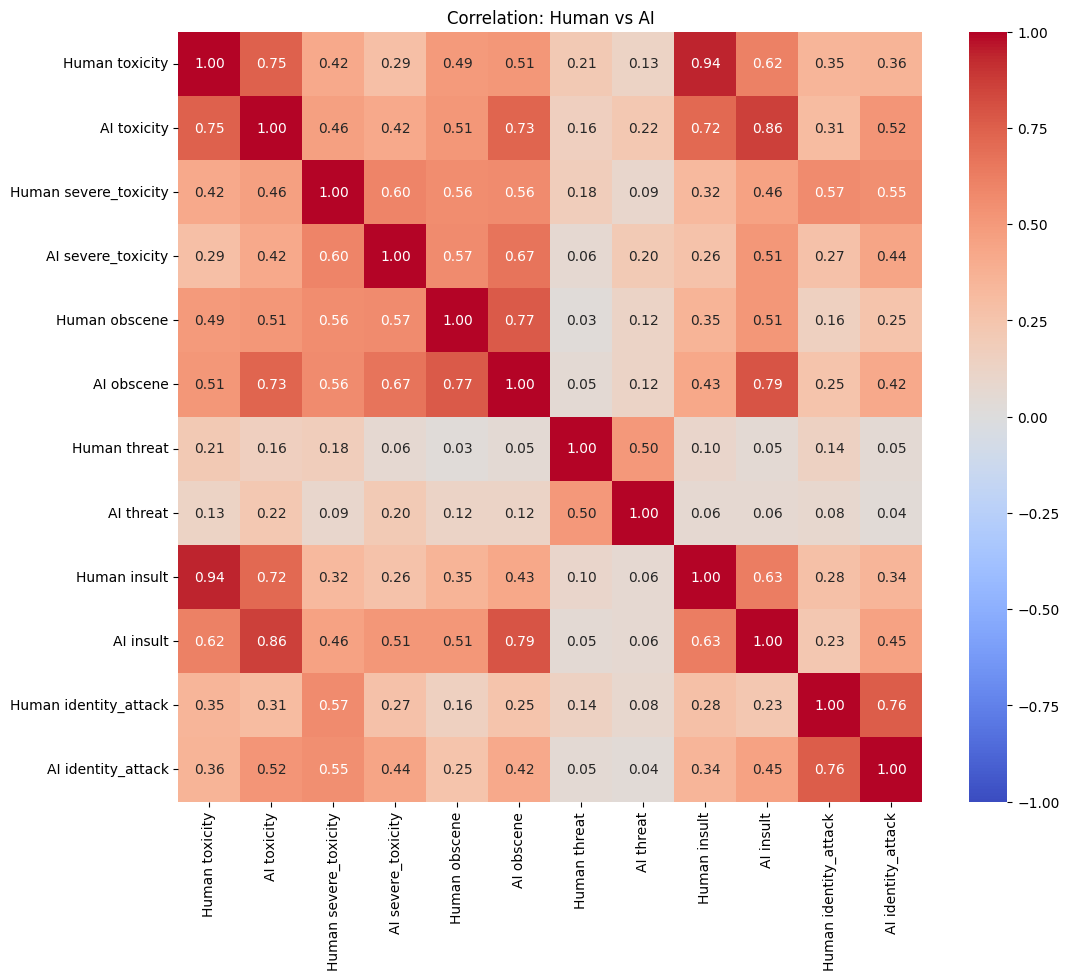

🖼️  Saved: bert_correlation_heatmap.png


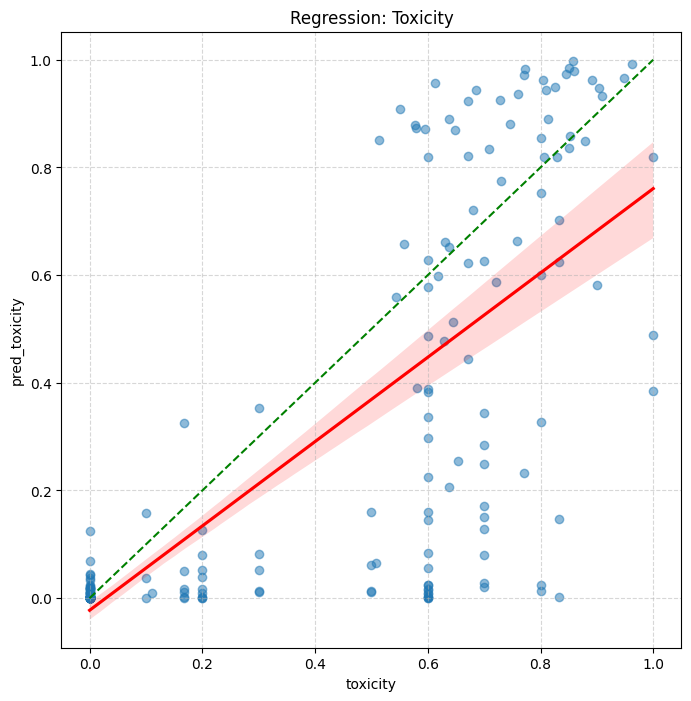

🖼️  Saved: bert_regression_plot.png

--- Mean Absolute Error (MAE) ---
toxicity             | MAE: 0.1750
severe_toxicity      | MAE: 0.0152
obscene              | MAE: 0.0657
threat               | MAE: 0.0188
insult               | MAE: 0.2168
identity_attack      | MAE: 0.0419


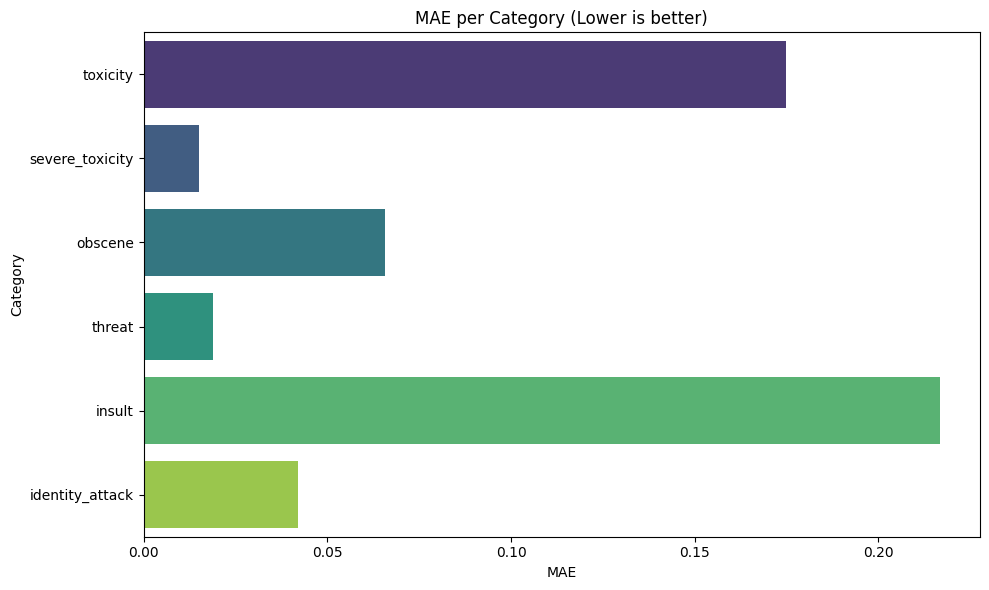

🖼️  Saved: bert_detailed_mae_bar.png


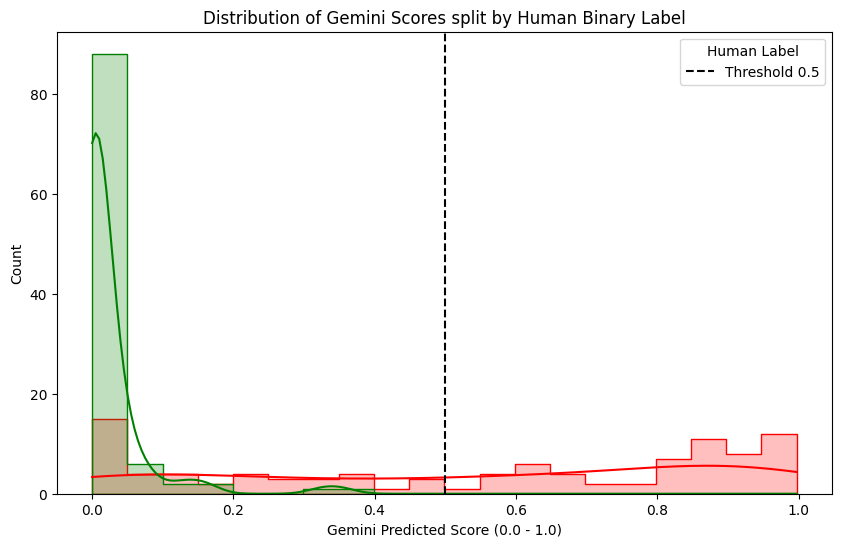

In [49]:
df = pd.read_csv(INPUT_CSV)
df = df.loc[df.lang=='eng', :].reset_index(drop=True)
result_df = run_bert_inference(df)
df_clean = preprocess_labels(result_df)
df_clean.to_csv(OUTPUT_CSV)
evaluate_binary_global(df_clean)
evaluate_detailed_subset(df_clean)